In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
%matplotlib inline

In [2]:
# FUNCTIONS YOU CAN USE:
#     analyses(filepath) spits out a nifty heatmap to let you check correlation between variables
#
#     regress(option, df) churns out a saucy graph of the linear regression for the variables you provided, where
#       option is 'snr_total' or 'tsnr', whichever you want to make the dependent variable of your model
#       df is the pandas DataFrame containing your data. To modify which variables you want in your model, you'll
#             have to directly modify the regress function

In [3]:
# NOTABLE FILENAMES
# ../data/extractions/p2_BOLD.csv                  - all dates for p2_BOLD
# ../data/extractions/p2Xs4X35mm_BOLD.csv          - all dates for p2Xs4X35mm_BOLD
# ../data/extractions/anat.csv                     - all possible dates for anatomical data

In [4]:
def filter(option, df):
    is_p2 = df['Filetype'] == "task-rest_acq-p2_bold.json"
    is_x = df['Filetype'] == "task-rest_acq-p2Xs4X35mm_bold.json"
    
    if option == 'x':
        return df[is_x]
    elif option == 'p2':
        return df[is_p2]

In [2]:
def analyses(filepath):
    files = pd.read_csv(filepath)
    
    # FIRST CHECK: CONVERSION SOFTWARE VERSIONS
    check = files.iloc[0, 7]
    valid = True
    
    for i in files.index:
        if check != files.iloc[i, 7]:
            valid = False
            
    print("All Conversion Softwares are the same: " + str(valid))
    
    # SECOND CHECK: HEATMAP
    sns.heatmap(files.corr(), cmap=sns.diverging_palette(h_neg=240, h_pos=10, n=9, sep=1, center="dark"), center=0)

In [8]:
def add_seasonal_simple(df, col='Date', start='2017-01-01'):
    # Add a very simplistic seasonal regressors as cos and sin since some date in a year
    time_delta = df[col] - np.datetime64(start)
    time_delta_rad = time_delta.apply(lambda d: d.days) * 2 * np.pi / 365.25
    df['Seasonal (sin)'] = np.sin(time_delta_rad)
    df['Seasonal (cos)'] = np.cos(time_delta_rad)

In [9]:
def Ftest(model, var_prefix):
    var_columns = [c for c in model.params.index if c.startswith(var_prefix)]
    if var_columns:
        f_test = model.f_test(' = '.join(var_columns) + " = 0")
        print("%s F-test: %s" % (var_prefix, f_test))
        return f_test
    else:
        print("No %s variables in the model" % var_prefix)
        return None

In [57]:
def regress(target_variable, model_df, plot=True):
    # creates a regression graph plotted against actual data from certain QA metrics
    #      target_variable: takes str value of either snr_total or tsnr to model against
    #      model_df       : takes pandas DataFrame with data to be used for predictive modeling
    #      plot           : boolean to turn the plotted graph on/off
    
    ########## target_variable MUST be snr_total OR tsnr
    if target_variable != 'snr_total' and target_variable != 'tsnr' and target_variable != 'gray':
        return "Target variable must be snr_total, tsnr or gray"
    
    if type(model_df) is not pd.core.frame.DataFrame:
        return "DataFrame must be of type pandas.core.frame.DataFrame"
    
    
    
    ########## adding seasonal curves to the model
    add_seasonal_simple(model_df)
    
    
    ########## Converting date to a format that can be parsed by statsmodels API
    model_df['Date'] = pd.to_datetime(model_df['Date'], format="%Y%m%d")
    model_df['Date2'] = model_df['Date'].map(pd.datetime.toordinal)
    
    # There is apparently a sample date (20170626) with SAR being unknown None/NaN
    # For now we will just filter out those samples
    if 'SAR' in model_df.columns:
        finite_SAR = np.isfinite(model_df['SAR'])
        if not np.all(finite_SAR):
            print("Following dates didn't have SAR, excluding them: %s" % str(model_df['Date'][~finite_SAR]))
            model_df = model_df[finite_SAR]
    
    
    ########## Assigning independent and dependent variables
    model_vars = []
    
    for item in model_df.std().iteritems():
        if item[0] != 'Date' and item[0] != target_variable and item[1] != 0:
            model_vars.append(item[0])

    X = model_df[model_vars]
    y = model_df[target_variable]
    X = X.sub(X.mean())
    X = sm.add_constant(X)
    
    model_df = sm.add_constant(model_df)
    
    
    ########## modeling predictions
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    
    
    
    ################ CODE FOR TESTING INDIVIDUAL VARIABLE EFFECTS ####################
    significant_variables = [] 
    
    # get p-values
    for key, value in dict(model.pvalues).items():
        if value < 0.05 or key.lower() == 'const':
            # identify statistically insignificant variables in df
            significant_variables.append(key)
    
    
    
    ######## set statistically insignificant variables to 0, then predict
        
    partial_fits = {}  # partial_fits = {}

    for variable in significant_variables:

        X2 = model_df.copy(True) # prepare for mods
        X2 = X2[model_vars]
        X2 = sm.add_constant(X2)

        for col in X2:
            if col != variable:
                X2[col] = 0
        
        partial_fits[str(variable)] = model.predict(X2)
        
    print("Statistically significant variables: " + str(significant_variables))
    
    ################ END CODE FOR TESTING INDIVIDUAL VARIABLE EFFECTS ####################
    
    if not plot:
        return model
    
    
    ######### converting the above predictions to a format that can be plotted
    
    plot_df = predictions.to_frame()       # new DataFrame containing only data needed for the plot
    plot_df.columns = ['full fit']
    plot_df = plot_df.join(model_df['Date'])
    plot_df = plot_df.join(model_df[target_variable])
    
    summation_df = None
    
    for key, value in partial_fits.items():
        column = value.to_frame()
        column.columns = ['partial fit']

        if summation_df is None:
            summation_df = column          # used to add up the values
        else:
            summation_df = summation_df.add(column, axis=1)
    
    plot_df = pd.concat([plot_df, summation_df], axis=1)
    
    # plotting the graph
    plt.figure(figsize=(15, 6))

    ax = sns.lineplot(x="Date", y=target_variable, data=plot_df, color="#ffffff")
    
    # plotting partial fit
    ax_partial = plt.twinx()
    sns.lineplot(x="Date", y="full fit", data=plot_df, color="r", ax=ax)
    if partial_fits:
        sns.lineplot(x="Date", y="partial fit", data=plot_df, color="#ffcccc", ax=ax_partial)
        ax_partial.legend(['partial fit'], loc='upper left')
    
    ax.legend(['actual', 'full fit'])
    
    # giving additional data
    print(model.summary())
    
    F_shim = Ftest(model, 'Shim')
    F_IOPD = Ftest(model, 'IOPD')
    F_seasonal = Ftest(model, 'Seasonal')
    return model

In [ ]:
#         #
#        # #
#       #   #
#      #     #
#     #########
#    #         #
#   #           #
#  #             #
# #               # NALYSES

All Conversion Softwares are the same: True


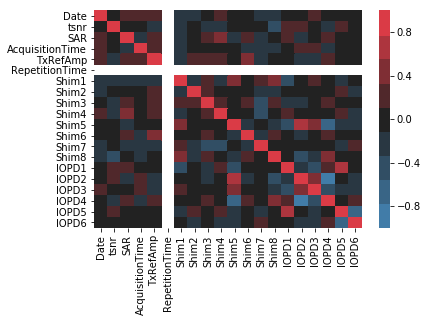

In [7]:
analyses('../data/extractions/p2_BOLD.csv')

All Conversion Softwares are the same: True


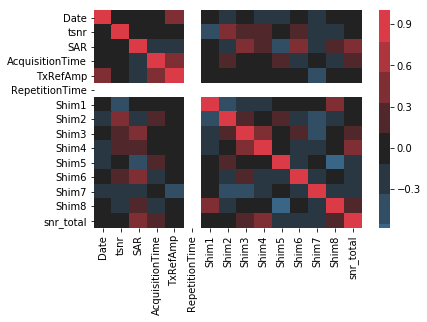

In [8]:
analyses('../data/extractions/p2_BOLD_snr.csv')

All Conversion Softwares are the same: True


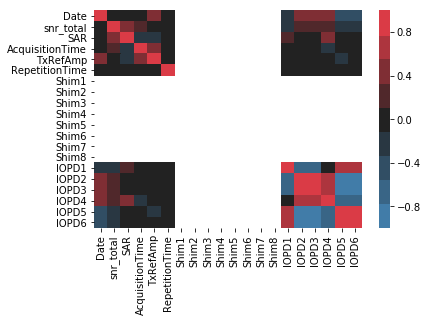

In [3]:
analyses('../data/extractions/anat.csv')

In [2]:
df = pd.read_csv('../data/extractions/p2_BOLD.csv', parse_dates=['Date'])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


Statistically significant variables: ['const', 'Shim6', 'Seasonal (cos)']
                            OLS Regression Results                            
Dep. Variable:                   tsnr   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     2.961
Date:                Thu, 16 May 2019   Prob (F-statistic):           0.000437
Time:                        10:56:44   Log-Likelihood:                -407.29
No. Observations:                  90   AIC:                             856.6
Df Residuals:                      69   BIC:                             909.1
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

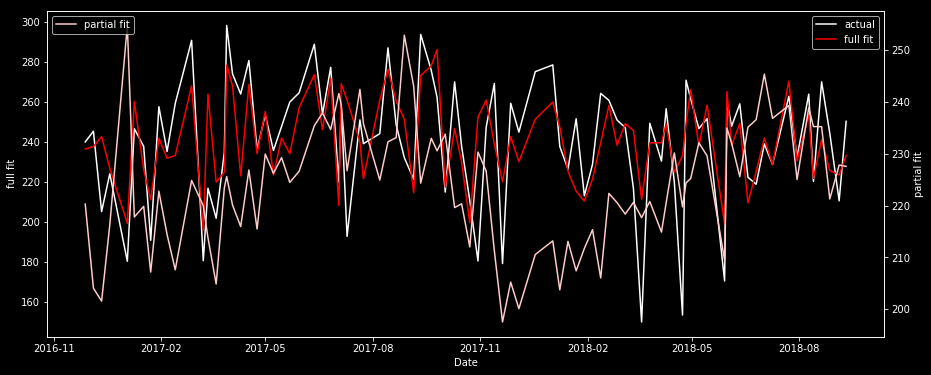

In [59]:
regress('tsnr', df)

In [20]:
# p2Xs4X35mm_BOLD.csv
df2 = pd.read_csv('../data/extractions/p2Xs4X35mm_BOLD.csv', parse_dates=['Date'])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


Statistically significant variables: ['const', 'Shim5']
                            OLS Regression Results                            
Dep. Variable:                   tsnr   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     4.297
Date:                Thu, 16 May 2019   Prob (F-statistic):           2.43e-06
Time:                        10:36:58   Log-Likelihood:                -383.96
No. Observations:                  90   AIC:                             811.9
Df Residuals:                      68   BIC:                             866.9
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

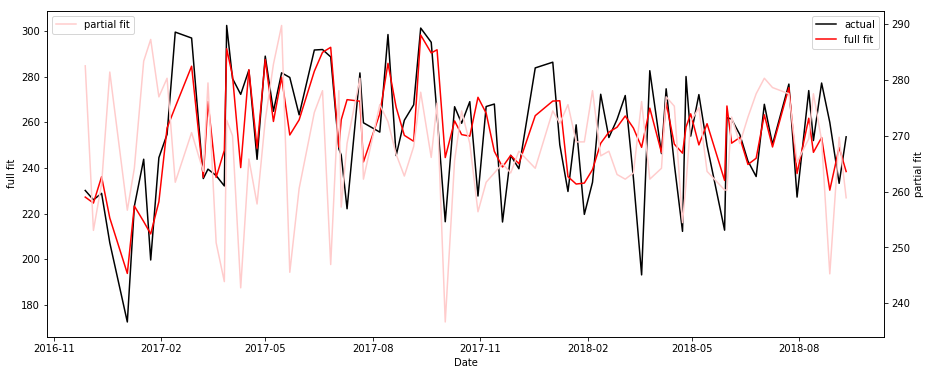

In [26]:
regress('tsnr', df2)

In [33]:
df3 = pd.read_csv('../data/extractions/anat.csv', parse_dates=['Date'])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


Statistically significant variables: []
                            OLS Regression Results                            
Dep. Variable:              snr_total   R-squared:                    -364.594
Model:                            OLS   Adj. R-squared:               -490.267
Method:                 Least Squares   F-statistic:                    -2.901
Date:                Thu, 16 May 2019   Prob (F-statistic):               1.00
Time:                        10:40:09   Log-Likelihood:                -234.52
No. Observations:                  44   AIC:                             493.0
Df Residuals:                      32   BIC:                             514.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
SA

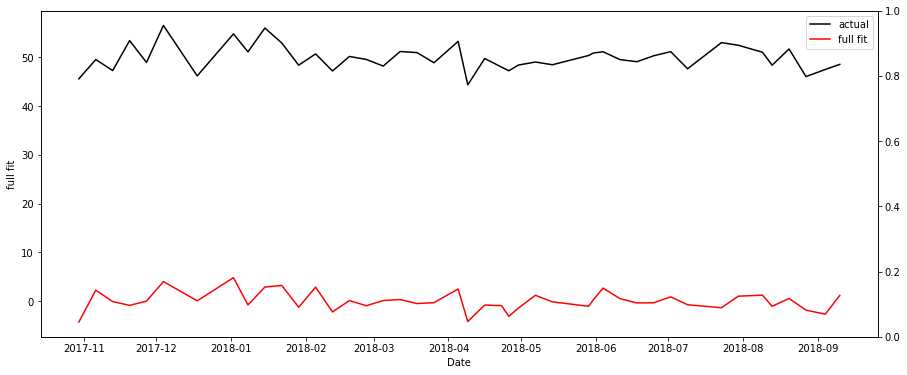

In [34]:
regress('snr_total', df3)

In [35]:
real_files = pd.read_csv('../output/real_output.csv')
real_df = pd.DataFrame(real_files,columns=['Date', 'sid', 'ses', 'snr_total', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2',
                                'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])

segstats = pd.read_csv('../output/segstats-volume.csv')
seg_df = pd.DataFrame(segstats,columns=['Date', 'sid', 'ses', 'Background', "Left-Accumbens-area", 
                                        "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white"])
merged_df = pd.merge(real_df, seg_df, on=['sid', 'ses'], how='outer')
merged_df['Date_x'] = pd.to_datetime(merged_df['Date_x'], format="%Y%m%d")
merged_df.set_index('Date_x',inplace=True)
merged_df

,sid,ses,snr_total,TxRefAmp,AcquisitionTime,SAR,RepetitionTime,Shim1,Shim2,Shim3,...,Right-Accumbens-area,Right-Amygdala,Right-Caudate,Right-Hippocampus,Right-Pallidum,Right-Putamen,Right-Thalamus-Proper,csf,gray,white
Date_x,,,,,,,,,,,,,,,,,,,,,
2016-10-11,sub-sid000003,20161011X092931,12.176199,228.321,34773,0.046610,2.30,4153,-7690,-7492,...,442.968783,1688.027471,3268.476809,3543.750267,1760.800914,4587.099955,7838.965434,292997.718750,8.496853e+05,6.136589e+05
2017-02-14,sub-sid000005,20170214X120812,11.995018,258.474,44480,0.057880,2.30,4153,-7690,-7492,...,635.185595,1718.877083,4169.443674,4436.806975,1953.808741,5039.560927,8996.221381,279086.937500,9.059462e+05,7.412118e+05
2017-08-28,sub-sid000005,20170828X155317,13.083898,257.477,58313,0.059600,2.30,4153,-7690,-7492,...,594.052779,1803.515761,4095.088199,4337.930014,1979.912259,4977.070688,9061.084667,248674.781250,7.889210e+05,6.653368e+05
2017-08-29,sub-sid000005,20170829X171624,13.052024,265.239,62795,0.064612,2.30,4153,-7690,-7492,...,627.275438,1688.027471,4095.088199,4511.162449,1949.853663,5339.355871,9176.572957,281862.593750,8.714904e+05,7.198607e+05
2017-11-18,sub-sid000005,20171118X174426,13.184153,255.721,63930,0.055096,2.30,4146,-7686,-7488,...,621.738328,1703.847785,4100.625309,4282.558916,2001.269682,4947.012092,9038.936228,278994.406250,9.293572e+05,7.293204e+05
2017-02-13,sub-sid000007,20170213X131037,13.696513,253.806,48368,0.053773,2.30,4153,-7690,-7492,...,473.027379,1378.740338,3405.322522,4232.724928,1962.509914,5410.547283,9499.307356,214801.890625,7.374070e+05,6.415477e+05
2017-09-30,sub-sid000007,20170930X101910,12.540846,273.768,37228,0.070596,2.30,4146,-7686,-7488,...,435.849642,1431.738389,3410.068616,4318.945638,1967.256008,5504.678149,9863.965587,258066.468750,8.113044e+05,6.960376e+05
2017-10-04,sub-sid000007,20171004X101244,13.773062,264.229,36827,0.064534,2.30,4146,-7686,-7488,...,488.847693,1539.316522,3390.293224,4352.959312,1933.242333,5604.346125,9555.469470,248599.625000,8.340438e+05,6.870493e+05
2017-11-13,sub-sid000007,20171113X193049,13.851964,271.448,70745,0.068664,2.30,4146,-7686,-7488,...,491.220740,1546.435663,3423.515883,4352.959312,1979.912259,5609.092220,9606.094474,314915.968750,9.380308e+05,8.300230e+05


In [37]:
df3['Date'] = pd.to_datetime(df3['Date'], format="%Y%m%d")
df3.set_index('Date',inplace=True)
df_reindexed = df3.reindex(pd.date_range(start=df3.index.min(), end=df3.index.max(), freq='1D'))  
df_reindexed.index.names = ['Date_x']
interpolated_df = df_reindexed.interpolate(method='time')
interpolated_df

,Filetype,snr_total,SAR,AcquisitionTime,TxRefAmp,SoftwareVersions,CSV,RepetitionTime,Shim1,Shim2,...,Shim8,IOPD1,IOPD2,IOPD3,IOPD4,IOPD5,IOPD6,Seasonal (sin),Seasonal (cos),Date2
Date_x,,,,,,,,,,,,,,,,,,,,,
2017-10-30,acq-MPRAGE_T1w.json,45.609948,0.033092,39009.000000,230.573000,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146.0,-7686.0,...,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603,-0.885725,0.464210,736632.0
2017-10-31,NaN,46.176395,0.033102,39409.714286,230.703571,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,0.835695,0.320519,0.057667,-0.183795,0.866906,0.012596,-0.876842,0.478930,736633.0
2017-11-01,NaN,46.742842,0.033112,39810.428571,230.834143,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,0.694933,0.426002,0.098311,-0.152903,0.772681,-0.148411,-0.867960,0.493650,736634.0
2017-11-02,NaN,47.309289,0.033121,40211.142857,230.964714,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,0.554171,0.531484,0.138956,-0.122010,0.678457,-0.309418,-0.859077,0.508369,736635.0
2017-11-03,NaN,47.875736,0.033131,40611.857143,231.095286,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425,-0.850195,0.523089,736636.0
2017-11-04,NaN,48.442183,0.033141,41012.571429,231.225857,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,0.272647,0.742449,0.220246,-0.060225,0.490009,-0.631432,-0.841312,0.537808,736637.0
2017-11-05,NaN,49.008630,0.033150,41413.285714,231.356429,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0
2017-11-06,acq-MPRAGE_T1w.json,49.575077,0.033160,41814.000000,231.487000,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146.0,-7686.0,...,64.0,-0.008877,0.953414,0.301535,0.001560,0.301560,-0.953446,-0.823547,0.567248,736639.0
2017-11-07,NaN,49.251327,0.033173,41217.428571,231.464000,NaN,NaN,2.3,4146.0,-7686.0,...,64.0,-0.028902,0.951493,0.302313,-0.007970,0.301400,-0.953178,-0.812961,0.580794,736640.0


In [38]:
super_df = pd.merge(merged_df, interpolated_df, left_index=True, right_index=True, suffixes = ("_real", "_qa"))
super_df

,sid,ses,snr_total_real,TxRefAmp_real,AcquisitionTime_real,SAR_real,RepetitionTime_real,Shim1_real,Shim2_real,Shim3_real,...,Shim8_qa,IOPD1_qa,IOPD2_qa,IOPD3_qa,IOPD4_qa,IOPD5_qa,IOPD6_qa,Seasonal (sin),Seasonal (cos),Date2
Date_x,,,,,,,,,,,,,,,,,,,,,
2017-10-30,sub-sid000496,20171030X191622,11.073170,301.097,69686,0.053360,2.3,4146,-7686,-7488,...,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603,-0.885725,0.464210,736632.0
2017-10-30,sub-sid000671,20171030X201904,13.257334,239.409,73440,0.056120,2.3,4146,-7686,-7488,...,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603,-0.885725,0.464210,736632.0
2017-10-31,sub-sid000013,20171031X200034,12.908929,228.607,72731,0.047360,2.3,4146,-7686,-7488,...,64.0,0.835695,0.320519,0.057667,-0.183795,0.866906,0.012596,-0.876842,0.478930,736633.0
2017-11-01,sub-sid000009,20171101X195906,12.986074,246.713,72619,0.055586,2.3,4146,-7686,-7488,...,64.0,0.694933,0.426002,0.098311,-0.152903,0.772681,-0.148411,-0.867960,0.493650,736634.0
2017-11-03,sub-sid000677,20171103X190009,11.148881,244.822,68937,0.057679,2.3,4146,-7686,-7488,...,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425,-0.850195,0.523089,736636.0
2017-11-03,sub-sid000678,20171103X200909,14.231328,226.757,73221,0.051241,2.3,4146,-7686,-7488,...,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425,-0.850195,0.523089,736636.0
2017-11-05,sub-sid000024,20171105X200345,12.615811,268.301,72794,0.058591,2.3,4146,-7686,-7488,...,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0
2017-11-05,sub-sid000494,20171105X121747,13.041954,250.491,44508,0.065390,2.3,4146,-7686,-7488,...,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0
2017-11-05,sub-sid000679,20171105X100749,11.297897,226.806,36978,0.056067,2.3,4146,-7686,-7488,...,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0


In [47]:
demographic_df = pd.read_csv('../data/dbic/bids/participants.tsv', sep='\t')
demographic_df = demographic_df.rename(index=str, columns={"participant_id": "sid"})
final_df = super_df.join(demographic_df.set_index('sid'), on='sid', how='left')
final_df

,sid,ses,snr_total_real,TxRefAmp_real,AcquisitionTime_real,SAR_real,RepetitionTime_real,Shim1_real,Shim2_real,Shim3_real,...,IOPD2_qa,IOPD3_qa,IOPD4_qa,IOPD5_qa,IOPD6_qa,Seasonal (sin),Seasonal (cos),Date2,age,sex
Date_x,,,,,,,,,,,,,,,,,,,,,
2017-10-30,sub-sid000496,20171030X191622,11.073170,301.097,69686,0.053360,2.3,4146,-7686,-7488,...,0.215037,0.017022,-0.214688,0.961130,0.173603,-0.885725,0.464210,736632.0,18,M
2017-10-30,sub-sid000671,20171030X201904,13.257334,239.409,73440,0.056120,2.3,4146,-7686,-7488,...,0.215037,0.017022,-0.214688,0.961130,0.173603,-0.885725,0.464210,736632.0,19,M
2017-10-31,sub-sid000013,20171031X200034,12.908929,228.607,72731,0.047360,2.3,4146,-7686,-7488,...,0.320519,0.057667,-0.183795,0.866906,0.012596,-0.876842,0.478930,736633.0,27,F
2017-11-01,sub-sid000009,20171101X195906,12.986074,246.713,72619,0.055586,2.3,4146,-7686,-7488,...,0.426002,0.098311,-0.152903,0.772681,-0.148411,-0.867960,0.493650,736634.0,27,M
2017-11-03,sub-sid000677,20171103X190009,11.148881,244.822,68937,0.057679,2.3,4146,-7686,-7488,...,0.636967,0.179601,-0.091118,0.584233,-0.470425,-0.850195,0.523089,736636.0,19,F
2017-11-03,sub-sid000678,20171103X200909,14.231328,226.757,73221,0.051241,2.3,4146,-7686,-7488,...,0.636967,0.179601,-0.091118,0.584233,-0.470425,-0.850195,0.523089,736636.0,21,F
2017-11-05,sub-sid000024,20171105X200345,12.615811,268.301,72794,0.058591,2.3,4146,-7686,-7488,...,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0,31,M
2017-11-05,sub-sid000494,20171105X121747,13.041954,250.491,44508,0.065390,2.3,4146,-7686,-7488,...,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0,18,F
2017-11-05,sub-sid000679,20171105X100749,11.297897,226.806,36978,0.056067,2.3,4146,-7686,-7488,...,0.847932,0.260890,-0.029333,0.395784,-0.792439,-0.832430,0.552528,736638.0,19,F


In [52]:
# need to slice a prepared DataFrame first
real_data_df = pd.DataFrame(final_df,columns=['gray', 'age', 'sex', 'snr_total_qa'])
real_data_df = real_data_df.reset_index()
real_data_df = real_data_df.rename(columns={'Date_x': 'Date'})
real_data_df.sex[real_data_df.sex == 'M'] = 1
real_data_df.sex[real_data_df.sex == 'F'] = 0
real_data_df

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Date,gray,age,sex,snr_total_qa
0,2017-10-30,8.646347e+05,18,1,45.609948
1,2017-10-30,7.388941e+05,19,1,45.609948
2,2017-10-31,6.797624e+05,27,0,46.176395
3,2017-11-01,7.363858e+05,27,1,46.742842
4,2017-11-03,6.829566e+05,19,0,47.875736
5,2017-11-03,5.824921e+05,21,0,47.875736
6,2017-11-05,7.327099e+05,31,1,49.008630
7,2017-11-05,1.023724e+06,18,0,49.008630
8,2017-11-05,7.930209e+05,19,0,49.008630
9,2017-11-05,8.361739e+05,19,1,49.008630


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


Statistically significant variables: ['const', 'age', 'snr_total_qa', 'Seasonal (sin)']
                            OLS Regression Results                            
Dep. Variable:                   gray   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     6.721
Date:                Thu, 16 May 2019   Prob (F-statistic):           6.66e-06
Time:                        10:54:55   Log-Likelihood:                -3529.3
No. Observations:                 261   AIC:                             7071.
Df Residuals:                     255   BIC:                             7092.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

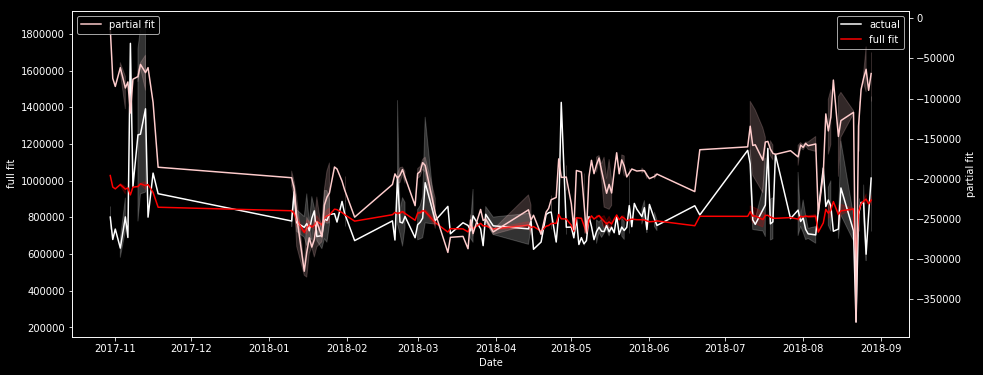

In [58]:
regress('gray', real_data_df)